In [1]:
import sys
parentdir = 'C:\\Users\\anaxa\\Documents\\Projects\\Synthetic avatar\\BAMT'
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import operator
from copy import copy
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from typing import Tuple
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler

In [3]:
def calculate_acc_res(bn: HyBayesianNetwork, data: pd.DataFrame, columns: list, method: str, normed: str = 'none') -> Tuple[dict, list, list]:
    """Function for calculating of params restoration accuracy

    Args:
        bn (HyBayesianNetwork): fitted BN
        data (pd.DataFrame): test dataset
        columns (list): list of params for restoration
        method (str): method of sampling - simple or mix
        normed (str, optional): type of rmse normalization (range, std, none). Defaults to 'none'.

    Returns:
        Tuple[dict, dict, list, list]: accuracy, rmse, real data, predicted data
    """    
    rmse_dict = dict()
    pred_param = [[0 for j in range(data.shape[0])] for i in range(len(columns))]
    real_param = [[0 for j in range(data.shape[0])] for i in range(len(columns))]
    for i in range(data.shape[0]):
        print(i)
        test = dict(data.iloc[i, :])
        for n, key in enumerate(columns):
            train_dict = copy(test)
            train_dict.pop(key)
            try:
                agg = SampleAggregator()
                sample = agg.aggregate(bn.randomsample(2000, method, train_dict))
                sorted_res = sorted(sample[key].items(), key=operator.itemgetter(1), reverse=True)
                pred_param[n][i] = int(sorted_res[0][0])
                real_param[n][i] = int(test[key])
            except Exception as ex:
                print(ex)
                pred_param[n][i] = np.nan
                real_param[n][i] = np.nan
    for i in range(len(columns)):
        pred_param[i] = [k for k in pred_param[i] if str(k) != 'nan']
        real_param[i] = [k for k in real_param[i] if str(k) != 'nan']
    for n, key in enumerate(columns):
        
        if normed == 'range':
            rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False) / (np.max(real_param[n]) - np.min(real_param[n])), 3)
        elif normed == 'std':
            std = np.std(real_param[n])
            rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False) / std, 3)
        elif normed == 'none':
            rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False), 3)
    return rmse_dict, real_param, pred_param


In [303]:
act_names = dict()
act_names['Изготовление металоконструкций траверс act'] = 'Изготовление металлоконструкций траверс act'
act_names['Монтаж волоконно-оптического кабеля по металлоконструкциям act'] = 'Монтаж ВОК по металлоконструкциям act'
act_names['Монтаж металоконструкций траверс act'] = 'Монтаж металлоконструкций траверс act'
act_names['Монтаж муфты оптической на опоре 86/1 act'] = 'Монтаж муфты оптической на опоре act'
act_names['Монтаж муфты оптической на опоре сущ1, сущ2 act'] = 'Монтаж муфты оптической на опоре act'
act_names['Монтаж оголовков act'] = 'Монтаж оголовников свай act'
act_names['Монтаж опор (направляющие, скользящие, неподвижные) act'] = 'Монтаж опор act'
act_names['Монтаж опор (направляющие. скользящие. неподвижные) act'] = 'Монтаж опор act'
act_names['Срезка свай (под отметку) act'] = 'Срезка свай act'


In [304]:
res_names = dict()
res_names['Автобетономеситель 6*6 КАМАЗ res'] = 'Автобетоносмеситель res'
res_names['Автокран (25 тн) res'] = 'Автокран res'
res_names['Автокран КС 45721 res'] = 'Автокран res'
res_names['Автомобиль ("Нива", "Петрович") res'] = 'Автомобиль res'
res_names['Автомобиль вахтовый res'] = 'Автомобиль res'
res_names['Бетонщики res'] = 'Бетонщик res'
res_names['Бульдозер САТ Д6 res'] = 'Бульдозер res'
res_names['Бульдозер типа САТ D6 res'] = 'Бульдозер res'
res_names['Бульдозер. трактор res'] = 'Бульдозер res'
res_names['Бурильная машина БМ-811 res'] = 'Бурильная машина res'
res_names['Вахта (Камаз) res'] = 'Вахтовый автомобиль res'
res_names['Газорезчики res'] = 'Газорезчик res'
res_names['ДЭС DENYO 2х пост res'] = 'ДЭС res'
res_names['Изолировщики res'] = 'Изолировщик res'
res_names['Маляры, изолировщики res'] = 'Маляр res'
res_names['Механизаторы. водители res'] = 'Механизаторы res'
res_names['Механик-водитель res'] = 'Механик res'
res_names['Монтажники res'] = 'Монтажник res'
res_names['Разнорабочие res'] = 'Разнорабочий res'
res_names['Руководитель строительства res'] = 'Руководитель res'
res_names['Самосвал (20 тн) res'] = 'Самосвал res'
res_names['Сварочный пост/сварочный аппарат  res'] = 'Сварочный пост res'
res_names['Стропальщики res'] = 'Стропальщик res'
res_names['Трубоукладчик ТР-12.22.02 res'] = 'Трубоукладчик res'
res_names['Экскаватор  гидробур res'] = 'Экскаваторы res'
res_names['Экскаватор  ковш res'] = 'Экскаваторы res'
res_names['Экскаватор РС400 res'] = 'Экскаваторы res'
res_names['Электрик. электромонтажник res'] = 'Электромонтажник res'


## Формирование итоговой матрицы частот рёбер

In [321]:
df = pd.read_csv('../data/6_p.csv')
df = df.drop(columns = ['Unnamed: 0'])


In [322]:
new_col = []
for c in df.columns:
    if c in act_names.keys():
        new_col.append(act_names[c])
    elif c in res_names.keys():
        new_col.append(res_names[c])
    else:
        new_col.append(c)


In [323]:
df.columns = new_col

In [324]:
df = df.groupby(axis=1, level=0).sum()
df = df.astype(int)
df

,Бетонщик res,Бурение под сваи act,"ВЛ Кусты скважин №10,10.1 АС act","ВЛ Кусты скважин №10,10.1 АСЭ act",Газорезчик res,Заливка свай act,ИТР res,Механик res,Монтаж оголовников свай act,Монтаж опор act,Монтажник res,Погружение свай act,Подготовка вдоль трассового проезда act,Разнорабочий res,Руководитель res,Срезка свай act,Электромонтеры линейщики res,Электросварщики res
0,7,5,15,0,1,15,2,3,20,20,5,15,0,7,1,15,14,3
1,7,21,15,0,1,38,2,3,15,3,5,30,0,7,1,15,14,3
2,7,0,15,0,1,0,2,3,11,16,5,0,0,7,1,11,14,3
3,7,0,15,0,1,0,2,3,0,0,5,0,0,7,1,0,14,3
4,7,0,15,0,1,0,2,3,2,0,5,0,0,7,1,0,14,3
5,7,3,15,0,1,2,2,3,15,8,5,3,0,7,1,15,14,3
6,7,5,7,0,1,6,2,3,22,0,5,5,0,7,1,17,14,3
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [267]:
df_empty_column = []
for c in df.columns:
    if (df[c] == 0).all():
        df_empty_column.append(c)

In [268]:
df_empty_column

[]

In [269]:
columns = [c for c in df.columns.tolist() if c not in df_empty_column]
df = df[columns]

In [270]:
node_types = get_nodes_type(df)

In [271]:
act = [c for c in df.columns if c.split()[-1]=='act']
res = [c for c in df.columns if c.split()[-1]=='res']
num_act = len(act)
num_res = len(res)
df_act = df[act]
df_res = df[res]

<AxesSubplot:>

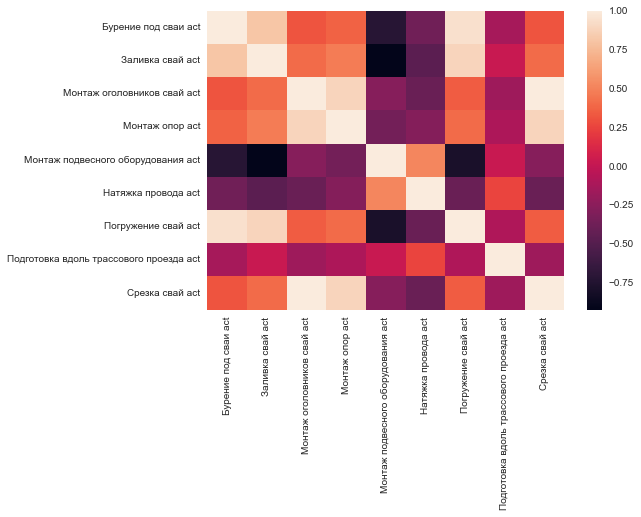

In [272]:
corr = df_act.corr('spearman')
sns.heatmap(corr)

In [273]:
corr

,Бурение под сваи act,Заливка свай act,Монтаж оголовников свай act,Монтаж опор act,Монтаж подвесного оборудования act,Натяжка провода act,Погружение свай act,Подготовка вдоль трассового проезда act,Срезка свай act
Бурение под сваи act,1.000000,0.811019,0.315689,0.368645,-0.725300,-0.371184,0.947066,-0.127655,0.315689
Заливка свай act,0.811019,1.000000,0.402224,0.469697,-0.924118,-0.472933,0.884894,0.026739,0.402224
Монтаж оголовников свай act,0.315689,0.402224,1.000000,0.884894,-0.276979,-0.404995,0.344444,-0.169929,1.000000
Монтаж опор act,0.368645,0.469697,0.884894,1.000000,-0.360406,-0.283760,0.402224,-0.103298,0.884894
Монтаж подвесного оборудования act,-0.725300,-0.924118,-0.276979,-0.360406,1.000000,0.511766,-0.791368,0.030043,-0.276979
Натяжка провода act,-0.371184,-0.472933,-0.404995,-0.283760,0.511766,1.000000,-0.404995,0.250389,-0.404995
Погружение свай act,0.947066,0.884894,0.344444,0.402224,-0.791368,-0.404995,1.000000,-0.092798,0.344444
Подготовка вдоль трассового проезда act,-0.127655,0.026739,-0.169929,-0.103298,0.030043,0.250389,-0.092798,1.000000,-0.169929
Срезка свай act,0.315689,0.402224,1.000000,0.884894,-0.276979,-0.404995,0.344444,-0.169929,1.000000


In [274]:
corr.fillna(0, inplace=True)

In [275]:
cosine_dist = np.empty((num_act, num_act))
for i, c1 in enumerate(act):
    for j, c2 in enumerate(act):
        cosine_dist[i, j] = distance.cosine(corr[c1].values, corr[c2].values)

In [276]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(cosine_dist)

In [277]:
corr['labels'] = kmeans.labels_

In [278]:
columns1 = corr.loc[corr['labels'] == 0].index.tolist()
columns1

['Монтаж подвесного оборудования act', 'Натяжка провода act']

In [279]:
columns2 = corr.loc[corr['labels'] == 1].index.tolist()
columns2

['Бурение под сваи act',
 'Заливка свай act',
 'Монтаж оголовников свай act',
 'Монтаж опор act',
 'Погружение свай act',
 'Срезка свай act']

In [280]:
columns3 = corr.loc[corr['labels'] == 2].index.tolist()
columns3

['Подготовка вдоль трассового проезда act']

In [281]:
df1 = df[columns1 + res]
df2 = df[columns2 + res]
df3 = df[columns3 + res]

In [282]:
white_list1 = []
for c1 in columns1:
    for c2 in res:
        white_list1.append((c1, c2))
        white_list1.append((c2, c1))

In [283]:
white_list2 = []
for c1 in columns2:
    for c2 in res:
        white_list2.append((c1, c2))
        white_list2.append((c2, c1))

In [284]:
white_list3 = []
for c1 in columns3:
    for c2 in res:
        white_list3.append((c1, c2))
        white_list3.append((c2, c1))

In [285]:
bn1 = structure_learning(df1, 'HC', node_types, 'K2', white_list=white_list1)

In [286]:
bn2 = structure_learning(df2, 'HC', node_types, 'K2', white_list=white_list2)

In [287]:
bn3 = structure_learning(df3, 'HC', node_types, 'K2', white_list=white_list3)

In [288]:
save_structure(bn1, 'file6_bn1')
save_structure(bn2, 'file6_bn2')
save_structure(bn3, 'file6_bn3')

In [118]:
all_acts = []
all_res = []
for i in range(1, 7):
    df = pd.read_csv('../data/'+str(i)+'.csv')
    for c in df.columns.tolist():
        if (c.split()[-1] == 'act') & (c not in all_acts):
            all_acts.append(c)
        if (c.split()[-1] == 'res') & (c not in all_res):
            all_res.append(c)

In [119]:
for i in range (len(all_acts)):
    if all_acts[i] in act_names.keys():
        all_acts[i] = act_names[all_acts[i]]
for i in range (len(all_res)):
    if all_res[i] in res_names.keys():
        all_res[i] = res_names[all_res[i]]

all_acts = list(dict.fromkeys(all_acts))
all_res = list(dict.fromkeys(all_res))

In [8]:
freq_edge = pd.DataFrame(data=np.zeros((len(all_acts), len(all_res))), columns=all_res)
freq_edge.index = all_acts


In [9]:
for i in range(1, 7):
    bn1 = read_structure('file'+str(i)+'_bn1')
    bn2 = read_structure('file'+str(i)+'_bn2')
    bn3 = read_structure('file'+str(i)+'_bn3')
    for edge in bn1.E:
        if edge[0].split()[-1] == 'act':
            freq_edge.loc[edge[0], edge[1]] += 1
        else:
            freq_edge.loc[edge[1], edge[0]] += 1
    for edge in bn2.E:
        if edge[0].split()[-1] == 'act':
            freq_edge.loc[edge[0], edge[1]] += 1
        else:
            freq_edge.loc[edge[1], edge[0]] += 1
    for edge in bn3.E:
        if edge[0].split()[-1] == 'act':
            freq_edge.loc[edge[0], edge[1]] += 1
        else:
            freq_edge.loc[edge[1], edge[0]] += 1
        

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

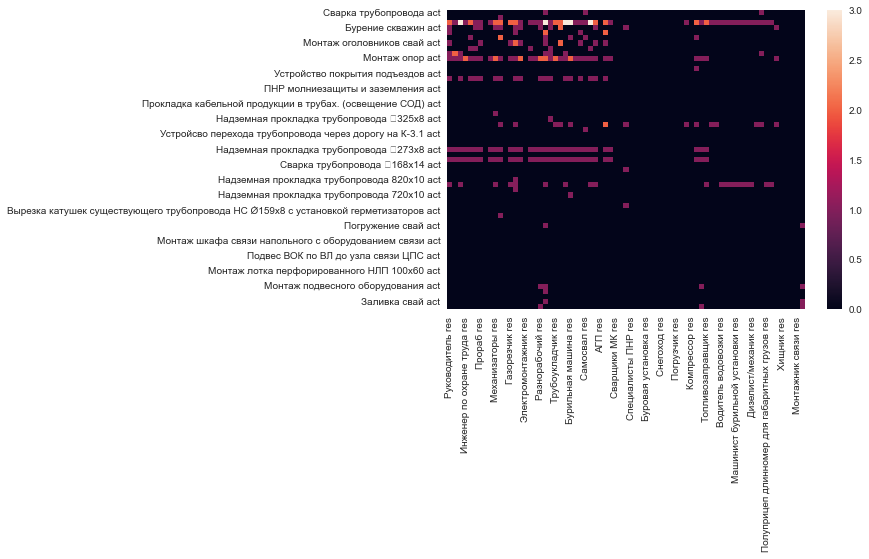

In [10]:
sns.heatmap(freq_edge)

In [11]:
empty_res = []
empty_act = []
for c in freq_edge.columns.tolist():
    if (freq_edge[c] == 0).all():
        empty_res.append(c)
for c in freq_edge.index.tolist():
    if (freq_edge.loc[c,:] == 0).all():
        empty_act.append(c)


## Построение сетей по файлам на основе матрицы частот

In [51]:
df = pd.read_csv('../data/1.csv')
df = df.drop(columns = ['Unnamed: 0'])
df = df.astype(int)

In [52]:
new_col = []
for c in df.columns:
    if c in act_names.keys():
        new_col.append(act_names[c])
    elif c in res_names.keys():
        new_col.append(res_names[c])
    else:
        new_col.append(c)


df.columns = new_col

df = df.groupby(axis=1, level=0).sum()

df_empty_column = []
for c in df.columns:
    if (df[c] == 0).all():
        df_empty_column.append(c)


columns = [c for c in df.columns.tolist() if c not in df_empty_column]
df = df[columns]

In [53]:
act = [c for c in df.columns if c.split()[-1]=='act']
res = [c for c in df.columns if c.split()[-1]=='res']

In [54]:
res

['Автобетоносмеситель res',
 'Автокран res',
 'Автомобиль res',
 'Бульдозер res',
 'Бурильная машина res',
 'Газорезчик res',
 'Геодезист res',
 'ИТР res',
 'Инженер ПТО res',
 'Инженер по охране труда res',
 'Инженер технического надзора res',
 'Механизаторы res',
 'Монтажник res',
 'Начальник участка res',
 'Прораб res',
 'Разнорабочий res',
 'Руководитель res',
 'Самосвал res',
 'Стропальщик res',
 'Трубоукладчик res',
 'Тягач с полуприцепом res',
 'Экскаваторы res',
 'Электросварщики res']

In [55]:
bn = dict()
bn['V'] = df.columns.tolist()
bn['E'] = []
for c2 in res:
    #parents = 0
    for c1 in act:
        if (freq_edge.loc[c1, c2] > 0): #& (parents < 4):
            bn['E'].append([c1, c2])
            #parents += 1

In [56]:
node_types = get_nodes_type(df)

In [26]:
draw_BN(bn, node_types, 'file3')

In [57]:
df_param = df.astype(str)
params = parameter_learning(df_param, node_types, bn, 'simple')

In [58]:
save_structure(bn, 'file3_structure')
skel = read_structure('file3_structure')
save_params(params, 'file3_param')
params = read_params('file3_param')
bn = HyBayesianNetwork(skel, params)

In [59]:
sample = generate_synthetics(bn, dict(), 'simple', 65)

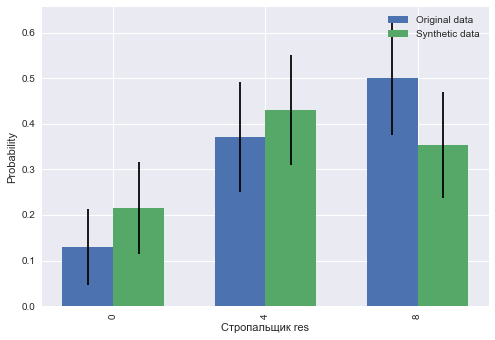

In [63]:
draw_comparative_hist('Стропальщик res', df_param, sample, node_types)

In [33]:
bn_part = dict()
bn_part['V'] = []
bn_part['E'] = []
for e in bn.E:
    if e[0] == act[5]:
        bn_part['E'].append(e)
        if e[0] not in bn_part['V']:
            bn_part['V'].append(e[0])
        if e[1] not in bn_part['V']:
            bn_part['V'].append(e[1])
        





In [34]:
draw_BN(bn_part, node_types, 'file3_part5')

In [35]:
rmse, real, pred = calculate_acc_res(bn, df_param, res, 'simple')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [36]:
rmse

{'А/м для перевозки воды res': 0.091,
 'Автобетоносмеситель res': 0.273,
 'Автокран res': 0.182,
 'Автомобиль res': 0.182,
 'Бетонщик res': 0.545,
 'Бульдозер res': 0.257,
 'Бурильная машина res': 0.273,
 'Вахтовый автомобиль res': 0.182,
 'Газорезчик res': 0.182,
 'Геодезист res': 0.273,
 'ДЭС res': 1.029,
 'ИТР res': 2.443,
 'Инженер ПТО res': 0.273,
 'Инженер по охране труда res': 0.091,
 'Инженер технического надзора res': 0.091,
 'Кладовщик res': 0.091,
 'Маляр res': 1.091,
 'Механизаторы res': 3.636,
 'Механик res': 0.091,
 'Монтажник res': 8.1,
 'Начальник участка res': 0.257,
 'ППУ res': 0.182,
 'Прораб res': 0.9,
 'Разнорабочий res': 0.273,
 'Руководитель res': 0.364,
 'Самосвал res': 0.182,
 'Стропальщик res': 0.771,
 'Топливозаправщик res': 0.091,
 'Трубоукладчик res': 0.455,
 'Тягач с полуприцепом res': 0.273,
 'Экскаваторы res': 0.455,
 'Электросварщики res': 5.727}

In [64]:
additional_edges = []
for e1 in res:
    for e2 in res:
        if e1 != e2:
            additional_edges.append((e1, e2))

In [65]:
init_edges = []
for e in bn.E:
    init_edges.append((e[0], e[1]))
    
    

In [19]:
bn_res = structure_learning(df[res], 'HC', node_types, 'K2')

In [20]:
bn_new = dict()
bn_new['V'] = df.columns.tolist()
bn_new['E'] = bn.E + bn_res['E']

In [66]:
bn_new = structure_learning(df, 'HC', node_types, 'K2', white_list=additional_edges, init_edges=init_edges, remove_init_edges=False)

In [21]:
draw_BN(bn_new, node_types, 'bn_new_file3')

In [67]:
params = parameter_learning(df_param, node_types, bn_new, 'simple')
save_structure(bn_new, 'file3_structure')
skel = read_structure('file3_structure')
save_params(params, 'file3_param')
params = read_params('file3_param')
bn = HyBayesianNetwork(skel, params)


In [68]:
sample = generate_synthetics(bn, dict(), 'simple', 65)

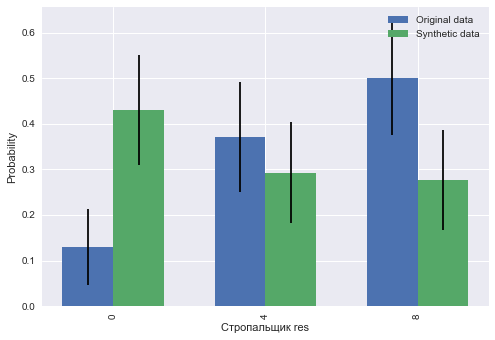

In [73]:
draw_comparative_hist('Стропальщик res', df_param, sample, node_types)

In [ ]:
rmse, real, pred = calculate_acc_res(bn, df_param, res, 'simple')

In [23]:
rmse

{'А/м для перевозки воды res': 0.0,
 'Автобетоносмеситель res': 0.0,
 'Автокран res': 0.0,
 'Автомобиль res': 0.0,
 'Бетонщик res': 0.0,
 'Бульдозер res': 0.0,
 'Бурильная машина res': 0.0,
 'Вахтовый автомобиль res': 0.0,
 'Газорезчик res': 0.0,
 'Геодезист res': 0.0,
 'ДЭС res': 0.0,
 'ИТР res': 0.0,
 'Инженер ПТО res': 0.0,
 'Инженер по охране труда res': 0.0,
 'Инженер технического надзора res': 0.0,
 'Кладовщик res': 0.0,
 'Маляр res': 0.0,
 'Механизаторы res': 0.0,
 'Механик res': 0.0,
 'Монтажник res': 0.0,
 'Начальник участка res': 0.0,
 'ППУ res': 0.0,
 'Прораб res': 0.0,
 'Разнорабочий res': 0.0,
 'Руководитель res': 0.0,
 'Самосвал res': 0.0,
 'Стропальщик res': 0.0,
 'Топливозаправщик res': 0.0,
 'Трубоукладчик res': 0.0,
 'Тягач с полуприцепом res': 0.0,
 'Экскаваторы res': 0.0,
 'Электросварщики res': 5.727}

## Использование N ближайших ресурсов

In [4]:
def get_n_nearest_by_corr(data, columns, number_res=5):
    groups = []
    for c in columns:
        close_ind = data[c].sort_values(ascending=False).index
        close_res = []
        for element in close_ind:
            if element.split()[-1] == 'res':
                close_res.append(element)
        groups.append([c]+close_res[0:number_res])
    return groups


def get_n_nearest_by_dist(data, columns, number_res=5):
    groups = []
    for c in columns:
        close_ind = data[c].sort_values().index
        close_res = []
        for element in close_ind:
            if element.split()[-1] == 'res':
                close_res.append(element)
        groups.append([c]+close_res[0:number_res])
    return groups


In [5]:
df = pd.read_csv('file3_fact.csv')
#df = df.drop(columns = ['Unnamed: 0'])


In [6]:
df = df.astype(float)
df

,А/м для перевозки воды res,Автобетоносмеситель res,Автокран res,Автомобиль res,Бетонщик res,Бульдозер res,Бурение скважин act,Бурильная машина res,Вахтовый автомобиль res,Газорезчик res,...,Топливозаправщик res,Трубоукладчик res,Тягач с полуприцепом res,Устройсво перехода трубопровода через дорогу (подход к основной магистрали) act,Устройсво перехода трубопровода через дорогу на К-3.1 act,Устройство свайного основания act,Экскаваторы res,"Электрик, электромонтажник res",Электросварщики res,технические ресурсы res
0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [7]:

df_empty_column = []
for c in df.columns:
    if (df[c] == 0).all():
        df_empty_column.append(c)


columns = [c for c in df.columns.tolist() if c not in df_empty_column]
df = df[columns]

In [8]:
act = [c for c in df.columns if c.split()[-1]=='act']
res = [c for c in df.columns if c.split()[-1]=='res']

In [60]:
len(res)

36

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


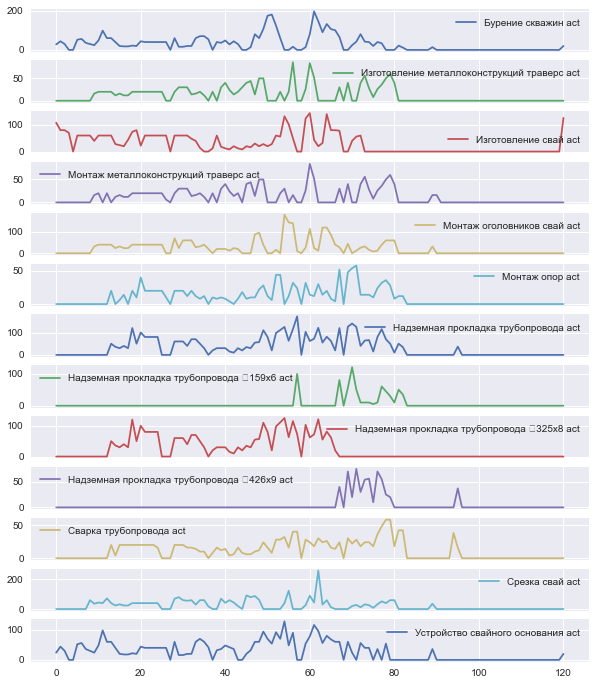

In [9]:
df[act].plot(subplots=True, figsize=(10,12))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

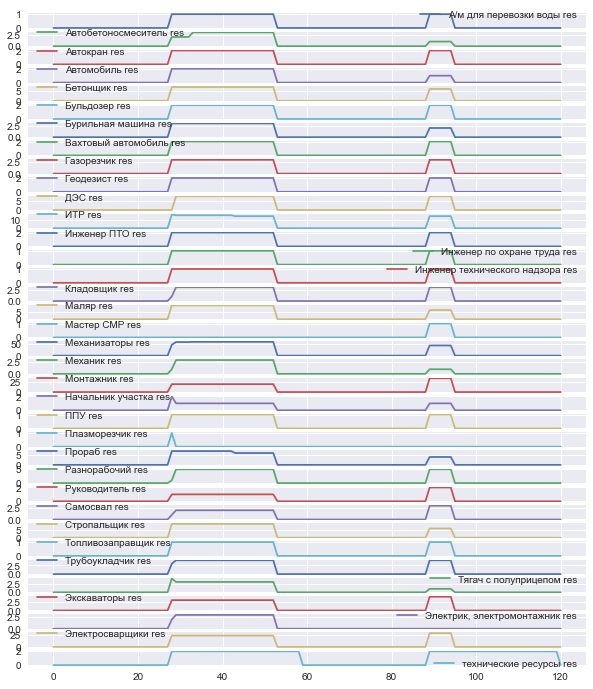

In [21]:
df[res].plot(subplots=True, figsize=(10,12))

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Экскаваторы res', ylabel='Density'>

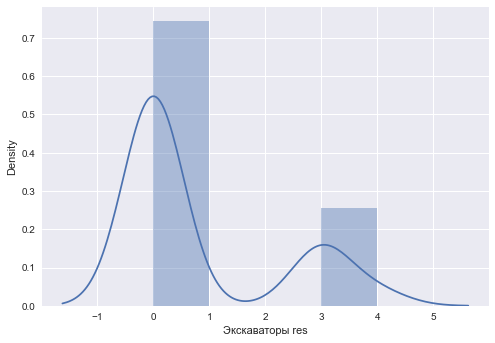

In [25]:
sns.distplot(df[res[-4]])

In [26]:
brave_act_res = pd.DataFrame(data=np.zeros((len(res), len(act))), columns=act)
brave_act_res.index = res

In [27]:
for c1 in act:
    act_seq = []
    for j in df.index.tolist():
        if df.loc[j,c1] != 0:
            act_seq.append(1)
        else:
            act_seq.append(0)
    for c2 in res:
        res_seq = []
        for i in df.index.tolist():
            if df.loc[i,c2] != 0:
                res_seq.append(1)
            else:
                res_seq.append(0)
        a = 0
        b = 0
        c = 0
        d = 0
        for e1, e2 in zip(act_seq, res_seq):
            if (e1 != 0) & (e2 != 0):
                a += 1
            if (e1 != 0) & (e2 == 0):
                b += 1
            if (e1 == 0) & (e2 != 0):
                c += 1
            if (e1 == 0) & (e2 == 0):
                d += 1
        br = (a*len(act_seq) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
        brave_act_res.loc[c2,c1] = br

        



    
        

In [28]:
brave_act_res

,Бурение скважин act,Изготовление металлоконструкций траверс act,Изготовление свай act,Монтаж металлоконструкций траверс act,Монтаж оголовников свай act,Монтаж опор act,Надземная прокладка трубопровода act,Надземная прокладка трубопровода ⌀159х6 act,Надземная прокладка трубопровода ⌀325х8 act,Надземная прокладка трубопровода ⌀426х9 act,Сварка трубопровода act,Срезка свай act,Устройство свайного основания act
А/м для перевозки воды res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Автобетоносмеситель res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Автокран res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Автомобиль res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Бетонщик res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Бульдозер res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Бурильная машина res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Вахтовый автомобиль res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Газорезчик res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655
Геодезист res,1.569394,1.288580,1.517406,1.326665,1.349073,1.472773,1.543562,0.229100,1.409777,0.203620,1.593449,1.266166,1.555655


In [17]:
corr = df.corr('spearman')

In [18]:
corr.fillna(0, inplace=True)

<AxesSubplot:>

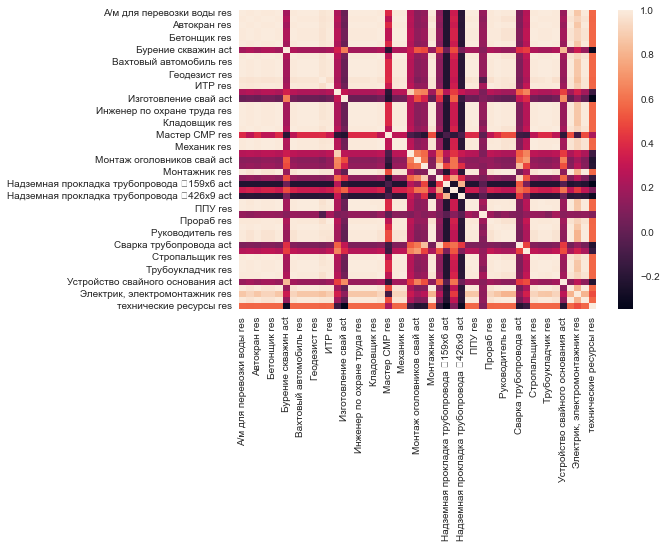

In [12]:
sns.heatmap(corr)

In [19]:
groups = get_n_nearest_by_corr(corr, act, number_res=7)

In [20]:
groups

[['Бурение скважин act',
  'Электрик, электромонтажник res',
  'Автобетоносмеситель res',
  'Механизаторы res',
  'Тягач с полуприцепом res',
  'Маляр res',
  'Бурильная машина res',
  'Автомобиль res'],
 ['Изготовление металлоконструкций траверс act',
  'Электрик, электромонтажник res',
  'Тягач с полуприцепом res',
  'Бетонщик res',
  'Бурильная машина res',
  'Маляр res',
  'Стропальщик res',
  'Автомобиль res'],
 ['Изготовление свай act',
  'Электрик, электромонтажник res',
  'Плазморезчик res',
  'Тягач с полуприцепом res',
  'Прораб res',
  'Автомобиль res',
  'Стропальщик res',
  'Маляр res'],
 ['Монтаж металлоконструкций траверс act',
  'Электрик, электромонтажник res',
  'Прораб res',
  'Тягач с полуприцепом res',
  'Стропальщик res',
  'Бетонщик res',
  'Бурильная машина res',
  'Автомобиль res'],
 ['Монтаж оголовников свай act',
  'Электрик, электромонтажник res',
  'Прораб res',
  'ИТР res',
  'Тягач с полуприцепом res',
  'Плазморезчик res',
  'Автомобиль res',
  'Бетонщик

In [15]:
df_normed = pd.DataFrame(data = MinMaxScaler().fit_transform(df.values), columns=df.columns)
df_normed

,А/м для перевозки воды res,Автобетоносмеситель res,Автокран res,Автомобиль res,Бетонщик res,Бульдозер res,Бурение скважин act,Бурильная машина res,Вахтовый автомобиль res,Газорезчик res,...,Срезка свай act,Стропальщик res,Топливозаправщик res,Трубоукладчик res,Тягач с полуприцепом res,Устройство свайного основания act,Экскаваторы res,"Электрик, электромонтажник res",Электросварщики res,технические ресурсы res
0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.187500,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.224490,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.343750,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.153061,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.234375,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0


In [38]:
distance_df = pd.DataFrame(data=np.zeros((len(res), len(act))), columns=act)
distance_df.index = res

In [39]:
for c1 in act:
    non_emty_act_ind = []
    for i in df.index:
        if df_normed.loc[i,c1] != 0:
            non_emty_act_ind.append(i)
    for c2 in res:
        distance_df.loc[c2, c1] = distance.euclidean(df.loc[:, c1].values, df.loc[:, c2].values)


In [40]:
groups = get_n_nearest_by_dist(distance_df, act, 7)

In [41]:
groups

[['Бурение скважин act',
  'Механизаторы res',
  'Электросварщики res',
  'Монтажник res',
  'ИТР res',
  'Стропальщик res',
  'Маляр res',
  'ДЭС res'],
 ['Изготовление металлоконструкций траверс act',
  'ИТР res',
  'Стропальщик res',
  'Маляр res',
  'Электросварщики res',
  'ДЭС res',
  'Бетонщик res',
  'Прораб res'],
 ['Изготовление свай act',
  'Электросварщики res',
  'ИТР res',
  'Монтажник res',
  'Маляр res',
  'Стропальщик res',
  'Бетонщик res',
  'ДЭС res'],
 ['Монтаж металлоконструкций траверс act',
  'ИТР res',
  'Электросварщики res',
  'Стропальщик res',
  'Маляр res',
  'ДЭС res',
  'Бетонщик res',
  'Прораб res'],
 ['Монтаж оголовников свай act',
  'Электросварщики res',
  'ИТР res',
  'Монтажник res',
  'Стропальщик res',
  'Маляр res',
  'ДЭС res',
  'Бетонщик res'],
 ['Монтаж опор act',
  'Стропальщик res',
  'Маляр res',
  'Бетонщик res',
  'Прораб res',
  'ИТР res',
  'ДЭС res',
  'Разнорабочий res'],
 ['Надземная прокладка трубопровода act',
  'Электросварщики

In [42]:
node_types = get_nodes_type(df)
node_sign = get_nodes_sign(df)

In [43]:
net = groups[1]
start_dag = []
white_list = []
for v1 in net:
    for v2 in net:
        if (v1.split()[-1] == 'act') & (v2.split()[-1] == 'res') & (v1!=v2):
            start_dag.append((v1, v2))
        if (v1.split()[-1] == 'res') & (v2.split()[-1] == 'res') & (v1!=v2):
            white_list.append((v1, v2))



In [44]:
bn = structure_learning(df[net], 'HC', node_types, 'K2', white_list = white_list, init_edges=start_dag, remove_init_edges=False)

In [45]:
draw_BN(bn, node_types, 'file3')

In [46]:
params = parameter_learning(df[net], node_types, bn, 'mix')

In [47]:
save_structure(bn, 'file_structure')
skel = read_structure('file_structure')
save_params(params, 'file_param')
params = read_params('file_param')
bn = HyBayesianNetwork(skel, params)

In [48]:
sample = generate_synthetics(bn, node_sign, 'mix', 130)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ИТР res', ylabel='Density'>

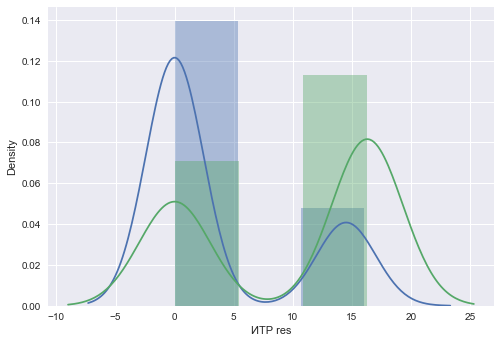

In [49]:
sns.distplot(df[net[1]])
sns.distplot(sample[net[1]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Стропальщик res', ylabel='Density'>

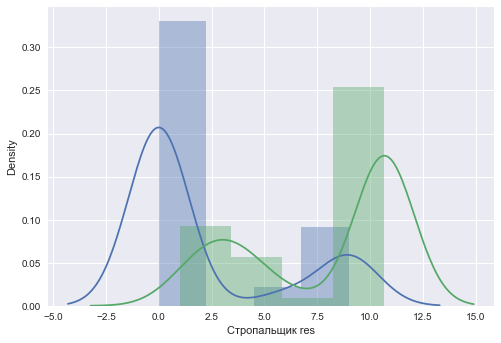

In [50]:
sns.distplot(df[net[2]])
sns.distplot(sample[net[2]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Маляр res', ylabel='Density'>

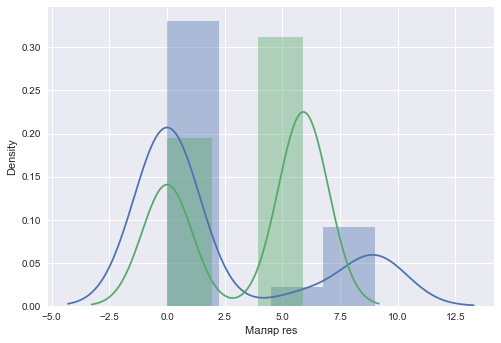

In [51]:
sns.distplot(df[net[3]])
sns.distplot(sample[net[3]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Электросварщики res', ylabel='Density'>

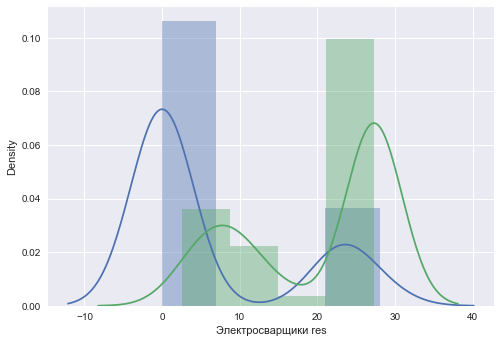

In [52]:
sns.distplot(df[net[4]])
sns.distplot(sample[net[4]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ДЭС res', ylabel='Density'>

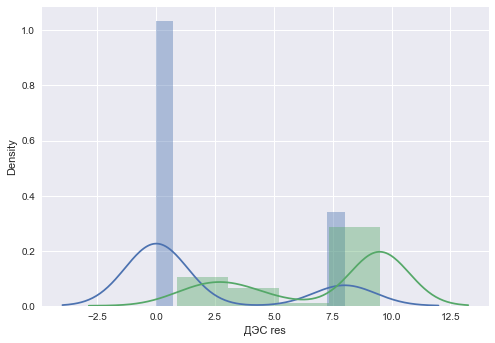

In [53]:
sns.distplot(df[net[5]])
sns.distplot(sample[net[5]])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Бетонщик res', ylabel='Density'>

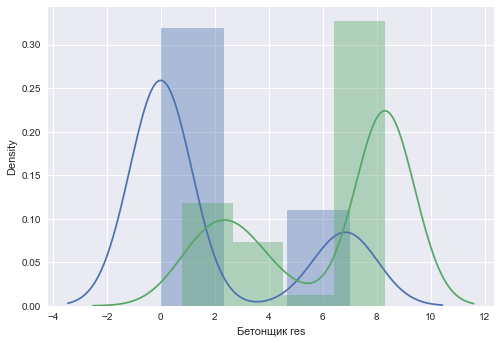

In [54]:
sns.distplot(df[net[6]])
sns.distplot(sample[net[6]])

In [55]:
acc, rmse, real, pred = LOO_validation(df[net], df[net].astype(int), 'mix', net[1:len(net)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:193: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [56]:
rmse

{'ИТР res': 6.728,
 'Стропальщик res': 0.786,
 'Маляр res': 0.801,
 'Электросварщики res': 1.85,
 'ДЭС res': 0.784,
 'Бетонщик res': 0.222,
 'Прораб res': 0.536}